# MNIST Point Cloud Classification

This task attempts to classify a set of 2D-points in the shape of a number. Using the MNIST dataset, point clouds are generated with a random number of points.

**Note:** the datasets are not included in this repository. Instead, they need to be generated using the [MNIST Point Cloud](https://github.com/DLii-Research/mnist-pointcloud) library.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import settransformer

2021-10-15 01:05:32.650748: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Strategy

Grab the appropriate compute device(s).

In [3]:
DEVICE = "gpu:0"
MULTI_GPU = False

In [5]:
if MULTI_GPU:
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.OneDeviceStrategy(DEVICE)

## Model Architecture

In [6]:
class PointCloudSetTransformer(keras.models.Model):
    def __init__(self, embed_dim=64, num_induce=32, num_heads=4):
        super(PointCloudSetTransformer, self).__init__()
        
        # Encoder
        inp = keras.layers.Input((None, 2))
        out = keras.layers.Dense(embed_dim)(inp)
        out = settransformer.InducedSetAttentionBlock(embed_dim, num_heads, num_induce, activation="gelu")(out)
        out = settransformer.InducedSetAttentionBlock(embed_dim, num_heads, num_induce, activation="gelu")(out)
        self.encoder = keras.models.Model(inp, out, name="Encoder")
        self.encoder.summary()
        
        # Decoder
        inp = keras.layers.Input((None, embed_dim))
        out = keras.layers.Dropout(0.5)(inp)
        out = settransformer.PoolingByMultiHeadAttention(1, embed_dim, 1, activation="gelu")(out)
        out = keras.layers.Dropout(0.5)(out)
        out = keras.layers.Dense(10)(out)
        self.decoder = keras.models.Model(inp, out, name="Decoder")
        self.decoder.summary()
        
    def call(self, x):
        return tf.squeeze(self.decoder(self.encoder(x)))

## Set Transformers Configuration

In [7]:
# Ensure the official MHA implementation is used rather than Keras
settransformer.config("use_keras_mha", False)

False

---
## 100-Element Point Clouds

In [21]:
# Point Clouds
with np.load("./datasets/mnist_point_cloud_train_100.npz") as f:
    x_train = f[list(f.keys())[0]]
    
with np.load("./datasets/mnist_point_cloud_test_100.npz") as f:
    x_test = f[list(f.keys())[0]]

# Labels
(_, y_train_labels), (_, y_test_labels) = keras.datasets.mnist.load_data()

# One-hot encoded labels
y_train = np.zeros((y_train_labels.size, y_train_labels.max()+1))
y_train[np.arange(y_train_labels.size), y_train_labels] = 1
y_test = np.zeros((y_test_labels.size, y_test_labels.max()+1))
y_test[np.arange(y_test_labels.size), y_test_labels] = 1

_ = None # Free memory

In [22]:
x_train.shape, x_test.shape

((60000, 100, 2), (10000, 100, 2))

In [23]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

### Model

In [24]:
with strategy.scope():
    model = PointCloudSetTransformer()
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=keras.metrics.SparseCategoricalAccuracy()
    )

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 2)]         0         
_________________________________________________________________
dense_14 (Dense)             (None, None, 64)          192       
_________________________________________________________________
induced_set_attention_block_ (None, None, 64)          35328     
_________________________________________________________________
induced_set_attention_block_ (None, None, 64)          35328     
Total params: 70,848
Trainable params: 70,848
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, 64)]        0         
______________________________________

In [25]:
model(x_train[:1])

2021-10-15 00:44:43.055787: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-15 00:44:43.260197: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([  6.4771013 ,   2.5262141 ,   6.0746417 , -12.665114  ,
         1.499412  ,   1.4662054 ,  -0.06396532,   6.378338  ,
       -10.120645  ,   6.9462247 ], dtype=float32)>

### Training

In [26]:
with strategy.scope():
    history = model.fit(x_train, y_train_labels, validation_split=0.2, epochs=20)

2021-10-15 00:44:48.951560: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3335"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = AutoS

Epoch 1/20
1496/1500 [============================>.] - ETA: 0s - loss: 1.3834 - sparse_categorical_accuracy: 0.5746

2021-10-15 00:45:00.647938: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9458"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = AutoS

1500/1500 [==============================] - 13s 8ms/step - loss: 1.3812 - sparse_categorical_accuracy: 0.5752 - val_loss: 0.5004 - val_sparse_categorical_accuracy: 0.8332
Epoch 2/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.5952 - sparse_categorical_accuracy: 0.8060 - val_loss: 0.3955 - val_sparse_categorical_accuracy: 0.8706
Epoch 3/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.4768 - sparse_categorical_accuracy: 0.8464 - val_loss: 0.3304 - val_sparse_categorical_accuracy: 0.8938
Epoch 4/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.4053 - sparse_categorical_accuracy: 0.8710 - val_loss: 0.3395 - val_sparse_categorical_accuracy: 0.8928
Epoch 5/20
1500/1500 [==============================] - 11s 8ms/step - loss: 0.3445 - sparse_categorical_accuracy: 0.8931 - val_loss: 0.2741 - val_sparse_categorical_accuracy: 0.9112
Epoch 6/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3056 - sparse_cat

In [28]:
with strategy.scope():
    model.evaluate(x_test, y_test_labels, batch_size=1)

   15/10000 [..............................] - ETA: 1:19 - loss: 0.0177 - sparse_categorical_accuracy: 1.0000   

2021-10-15 00:49:59.163443: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_84532"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = AutoS

10000/10000 [==============================] - 70s 7ms/step - loss: 0.1360 - sparse_categorical_accuracy: 0.9583


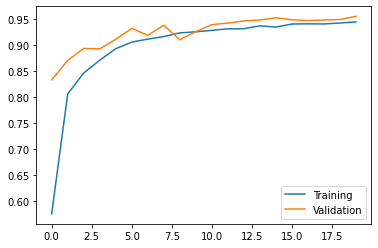

In [29]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.legend(["Training", "Validation"])
plt.show()

---
## 1000-Element Point Clouds

In [8]:
# Point Clouds
with np.load("./datasets/mnist_point_cloud_train_1000.npz") as f:
    x_train = f[list(f.keys())[0]]
    
with np.load("./datasets/mnist_point_cloud_test_1000.npz") as f:
    x_test = f[list(f.keys())[0]]

# Labels
(_, y_train_labels), (_, y_test_labels) = keras.datasets.mnist.load_data()

# One-hot encoded labels
y_train = np.zeros((y_train_labels.size, y_train_labels.max()+1))
y_train[np.arange(y_train_labels.size), y_train_labels] = 1
y_test = np.zeros((y_test_labels.size, y_test_labels.max()+1))
y_test[np.arange(y_test_labels.size), y_test_labels] = 1

_ = None # Free memory

In [9]:
x_train.shape, x_test.shape

((60000, 1000, 2), (10000, 1000, 2))

In [10]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

### Model

In [11]:
with strategy.scope():
    model = PointCloudSetTransformer()
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=keras.metrics.SparseCategoricalAccuracy()
    )

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 2)]         0         
_________________________________________________________________
dense (Dense)                (None, None, 64)          192       
_________________________________________________________________
induced_set_attention_block  (None, None, 64)          35328     
_________________________________________________________________
induced_set_attention_block_ (None, None, 64)          35328     
Total params: 70,848
Trainable params: 70,848
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 64)]        0         
______________________________________

In [25]:
model(x_train[:1])

2021-10-11 13:10:01.537753: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-11 13:10:01.748815: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.649069  , -1.5614321 ,  1.9313924 ,  1.334004  , -0.8865581 ,
        1.083253  , -0.50958705, -0.33919162, -3.3516853 , -0.31087857],
      dtype=float32)>

### Training

In [11]:
with strategy.scope():
    history = model.fit(x_train, y_train_labels, validation_split=0.2, epochs=20)

2021-10-15 01:07:09.288410: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 384000000 exceeds 10% of free system memory.
2021-10-15 01:07:09.462197: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 384000000 exceeds 10% of free system memory.
2021-10-15 01:07:09.674208: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1705"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    

Epoch 1/20
1499/1500 [============================>.] - ETA: 0s - loss: 1.3147 - sparse_categorical_accuracy: 0.6244

2021-10-15 01:07:46.763992: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 96000000 exceeds 10% of free system memory.
2021-10-15 01:07:46.822628: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 96000000 exceeds 10% of free system memory.
2021-10-15 01:07:46.877855: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8148"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    li

1500/1500 [==============================] - 40s 26ms/step - loss: 1.3144 - sparse_categorical_accuracy: 0.6246 - val_loss: 0.4493 - val_sparse_categorical_accuracy: 0.8545
Epoch 2/20
1500/1500 [==============================] - 38s 25ms/step - loss: 0.4612 - sparse_categorical_accuracy: 0.8551 - val_loss: 0.3089 - val_sparse_categorical_accuracy: 0.9082
Epoch 3/20
1500/1500 [==============================] - 38s 25ms/step - loss: 0.3457 - sparse_categorical_accuracy: 0.8942 - val_loss: 0.3205 - val_sparse_categorical_accuracy: 0.8947
Epoch 4/20
1500/1500 [==============================] - 38s 26ms/step - loss: 0.2924 - sparse_categorical_accuracy: 0.9115 - val_loss: 0.1755 - val_sparse_categorical_accuracy: 0.9445
Epoch 5/20
1500/1500 [==============================] - 37s 25ms/step - loss: 0.2585 - sparse_categorical_accuracy: 0.9217 - val_loss: 0.1825 - val_sparse_categorical_accuracy: 0.9405
Epoch 6/20
1500/1500 [==============================] - 38s 25ms/step - loss: 0.2274 - spar

In [12]:
with strategy.scope():
    model.evaluate(x_test, y_test_labels, batch_size=1)

2021-10-15 01:22:58.067498: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_82024"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = AutoS

10000/10000 [==============================] - 39s 4ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.9668


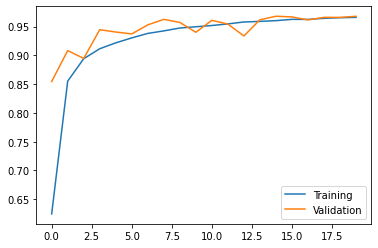

In [13]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.legend(["Training", "Validation"])
plt.show()